# Стохастический градиентный и координатный спуски

Для каждого задания указано количество баллов (если они оцениваются отдельно) + 1 балл за аккуратное и полное выполнение всего задания

## Загрузка и подготовка данных

**Загрузите уже знакомый вам файл *Advertising.csv* как объект DataFrame.** 

In [191]:
import pandas as pd

file_path = "Advertising.csv"
separator = ','
dataframe = pd.read_csv(file_path, sep=separator)

print(dataframe.head())

   id     TV  radio  newspaper  sales
0   1  230.1   37.8       69.2   22.1
1   2   44.5   39.3       45.1   10.4
2   3   17.2   45.9       69.3    9.3
3   4  151.5   41.3       58.5   18.5
4   5  180.8   10.8       58.4   12.9


**Проверьте, есть ли в данных пропуски и, если они есть - удалите их**

In [192]:
print("Before:")
print(dataframe.isnull().sum())

dataframe = dataframe.dropna()

print("After:")
print(dataframe.isnull().sum())

Before:
id           0
TV           0
radio        0
newspaper    0
sales        0
dtype: int64
After:
id           0
TV           0
radio        0
newspaper    0
sales        0
dtype: int64


**Преобразуйте ваши признаки в массивы NumPy и разделите их на переменные X (предикторы) и y(целевая переменная)** 

In [193]:
import numpy as np

X = dataframe.drop(columns=['sales','id'])  # Переменные-предикторы
y = dataframe['sales']  # Целевая переменная

print("Shape X:", X.shape)
print("Shape y:", y.shape)

Shape X: (200, 3)
Shape y: (200,)


## Координатный спуск (3 балла)

**Добавим единичный столбец для того, чтобы у нас был свободный коэффициент в уравнении регрессии:**

In [194]:
X = np.hstack([np.ones(X.shape[0]).reshape(-1, 1), X])

**Нормализуем данные: обычно это необходимо для корректной работы алгоритма**

In [195]:
X = X / np.sqrt(np.sum(np.square(X), axis=0))

**Реализуйте алгоритм координатного спуска:** (3 балла)

Ниже приведен алгоритм:

<a href="https://ibb.co/Th3BQFn"><img src="https://i.ibb.co/DK2DBS6/zascas.jpg" alt="zascas" border="0"></a>

Примечание: 1000 итераций здесь указаны для этого задания, на самом деле их может быть намного больше, нет детерменированного значения.

Вам необходимо реализовать координатный спуск, и вывести веса в модели линейной регрессии.

In [196]:
def coordinate_descent(X, y, num_iterations=1000):
    w = np.zeros(X.shape[1])
    for _ in range(num_iterations):
        for j in range(X.shape[1]):
            r = y - np.dot(X, w)
            r0 = r + X[:, j] * w[j]
            w[j] = np.dot(X[:, j], r0) / np.dot(X[:, j], X[:, j])
    return w

print(coordinate_descent(X, y))

[ 41.56217205 110.13144155  73.52860638  -0.55006384]


Сравните результаты с реализацией линейной регрессии из библиотеки sklearn:

In [197]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=False)
model.fit(X, y)
print(model.coef_)

[ 41.56217205 110.13144155  73.52860638  -0.55006384]


Если вы все сделали верно, они должны практически совпасть!

## Стохастический градиентный спуск (6 баллов)

**Отмасштабируйте столбцы исходной матрицы *X* (которую мы не нормализовали еще!). Для того, чтобы это сделать, надо вычесть из каждого значения среднее и разделить на стандартное отклонение** (0.5 баллов)

In [198]:
means = np.mean(X, axis=0)
stds = np.std(X, axis=0)
scaled_X = (X - means) / stds

**Добавим единичный столбец**

In [199]:
X = np.hstack([np.ones(X.shape[0]).reshape(-1, 1), X])

**Создайте функцию mse_error для вычисления среднеквадратичной ошибки, принимающую два аргумента: реальные значения и предсказывающие, и возвращающую значение mse** (0.5 балла)

In [200]:
def mse_error(y_true, y_pred):
    squared_errors = (y_true - y_pred) ** 2
    mse = np.mean(squared_errors)
    return mse

**Сделайте наивный прогноз: предскажите продажи средним значением. После этого рассчитайте среднеквадратичную ошибку для этого прогноза** (0.5 балла)

In [201]:
average = np.mean(y)
mse_average = mse_error(y, average)
print("MSE:", mse_average)

MSE: 27.085743750000002


**Создайте функцию *lin_pred*, которая может по матрице предикторов *X* и вектору весов линейной модели *w* получить вектор прогнозов** (0.5 балла)

In [202]:
def lin_pred(X, w):
    return X.dot(w)

**Создайте функцию *stoch_grad_step* для реализации шага стохастического градиентного спуска. (1.5 балла) 
Функция должна принимать на вход следующие аргументы:**
* матрицу *X*
* вектора *y* и *w*
* число *train_ind* - индекс объекта обучающей выборки (строки матрицы *X*), по которому считается изменение весов
* число *$\eta$* (eta) - шаг градиентного спуска

Результатом будет вектор обновленных весов

Шаг для стохастического градиентного спуска выглядит следующим образом:

$$\Large w_j \leftarrow w_j - \frac{2\eta}{\ell} \sum_{i=1}^\ell{{x_{ij}((w_0 + w_1x_{i1} + w_2x_{i2} +  w_3x_{i3}) - y_i)}}$$

Для того, чтобы написать функцию, нужно сделать следующее:
    
*  посчитать направление изменения: умножить объект обучающей выборки на 2 и на разницу между предсказанным значением и реальным, а потом поделить на количество элементов в выборке.
* вернуть разницу между вектором весов и направлением изменения, умноженным на шаг градиентного спуска

In [203]:
def stoch_grad_step(X, y, weights, train_ind, learning_rate):
    x_train_sample = X[train_ind, :]
    prediction = x_train_sample.dot(weights)
    error = prediction - y[train_ind]
    gradient = 2 * x_train_sample * error / len(y)
    updated_weights = weights - learning_rate * gradient

    return updated_weights

**Создайте функцию *stochastic_gradient_descent*, для реализации стохастического градиентного спуска (2.5 балла)**

**Функция принимает на вход следующие аргументы:**
- Матрицу признаков X
- Целевую переменнную
- Изначальную точку (веса модели)
- Параметр, определяющий темп обучения
- Максимальное число итераций
- Евклидово расстояние между векторами весов на соседних итерациях градиентного спуска,при котором алгоритм прекращает работу 

**На каждой итерации в вектор (список) должно записываться текущее значение среднеквадратичной ошибки. Функция должна возвращать вектор весов $w$, а также вектор (список) ошибок.**

Алгоритм сследующий:
    
* Инициализируйте расстояние между векторами весов на соседних итерациях большим числом (можно бесконечностью)
* Создайте пустой список для фиксации ошибок
* Создайте счетчик итераций
* Реализуйте оновной цикл обучения пока расстояние между векторами весов больше того, при котором надо прекратить работу (когда расстояния станут слишком маленькими - значит, мы застряли в одном месте) и количество итераций меньше максимально разрешенного: сгенерируйте случайный индекс, запишите текущую ошибку в вектор ошибок, запишите в переменную текущий шаг стохастического спуска с использованием функции, написанной ранее. Далее рассчитайте текущее расстояние между векторами весов и прибавьте к счетчику итераций 1.
* Верните вектор весов и вектор ошибок

In [204]:
def stochastic_gradient_descent(features, target, initial_weights, learning_rate, max_iterations, tolerance):
    weight_distance = float('inf')
    errors = []

    iteration = 0

    while weight_distance > tolerance and iteration < max_iterations:
        random_index = np.random.randint(len(target))
        updated_weights = stoch_grad_step(features, target, initial_weights, random_index, learning_rate)
        weight_distance = np.linalg.norm(updated_weights - initial_weights)
        current_error = mse_error(target, lin_pred(features, updated_weights))
        errors.append(current_error)
        initial_weights = updated_weights
        iteration += 1

    return initial_weights, errors


 **Запустите $10^5$ итераций стохастического градиентного спуска. Укажите вектор начальных весов, состоящий из нулей. Можете поэкспериментировать с параметром, отвечающим за темп обучения.**

**Постройте график зависимости ошибки от номера итерации**

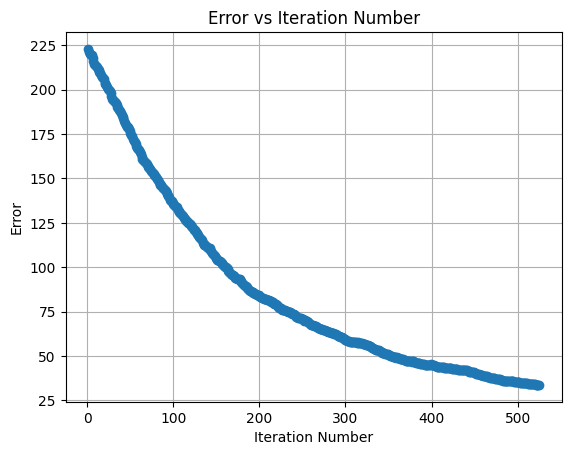

In [205]:
max_iterations = 100000

initial_weights = np.zeros(X.shape[1])
final_weights, errors_list = stochastic_gradient_descent(X, y, initial_weights, 0.3, max_iterations, 0.0001)
import matplotlib.pyplot as plt

plt.plot(range(1, len(errors_list) + 1), errors_list, marker='o', linestyle='-')
plt.title('Error vs Iteration Number')
plt.xlabel('Iteration Number')
plt.ylabel('Error')
plt.grid(True)
plt.show()

**Выведите вектор весов, к которому сошелся метод.**

In [206]:
print("Final wieghts:", final_weights)

Final wieghts: [11.14522353  0.78808631  0.90885201  0.8068773   0.65771398]


**Выведите среднеквадратичную ошибку на последней итерации.**

In [207]:
print("Last MSE:", errors_list[-1])

Last MSE: 33.7604113295047
